# Adding Delay to the FL technique

In [1]:
from FLController import *
from LQGController import *

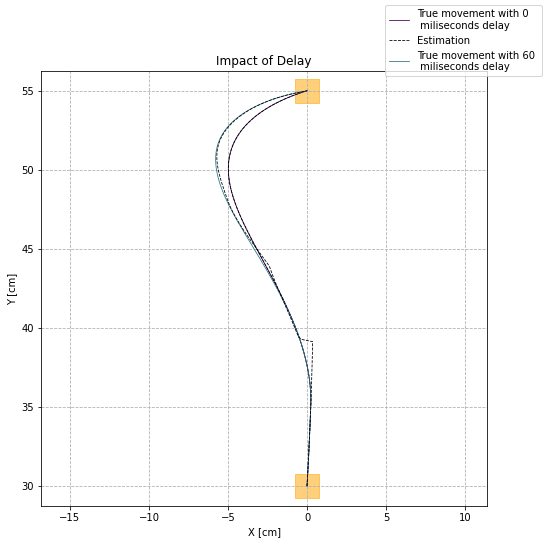

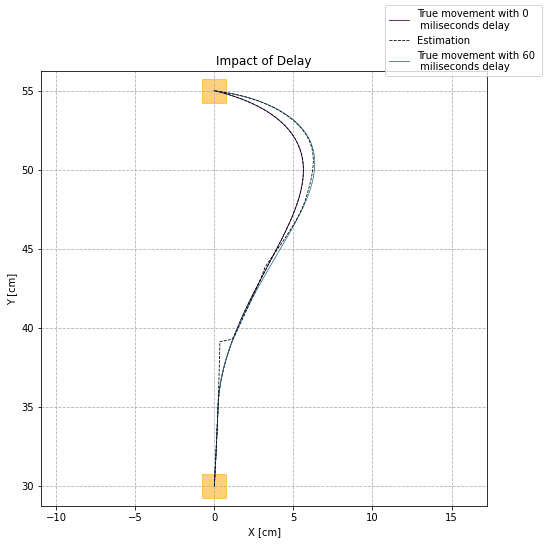

In [2]:
fig,ax = plt.subplots(figsize = (8,8))
for delay in [0,0.06]:
    Feedback_Linearization(Num_iter = 300,Delay=delay,ShowEstimate=True,Activate_Noise=False,alpha = 1e-1)

hand, labl = ax.get_legend_handles_labels()
handout,lablout =[],[]
for h,l in zip(hand,labl):
    if l not in lablout:
        lablout.append(l)
        handout.append(h)
fig.legend(handout, lablout)
plt.title("Impact of Delay")
plt.show()

fig,ax = plt.subplots(figsize = (8,8))
for delay in [0,0.06]:
    Feedback_Linearization(Num_iter = 300,Delay=delay,ShowEstimate=True,Activate_Noise=False,alpha = 1e-1,Side = "Right")

hand, labl = ax.get_legend_handles_labels()
handout,lablout =[],[]
for h,l in zip(hand,labl):
    if l not in lablout:
        lablout.append(l)
        handout.append(h)
fig.legend(handout, lablout)
plt.title("Impact of Delay")
plt.show()

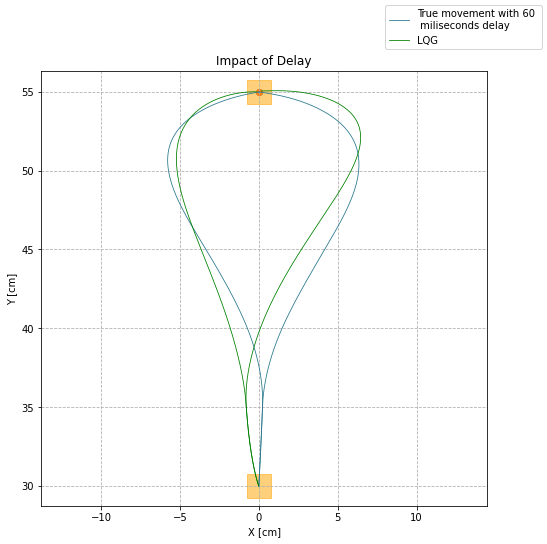

In [4]:
fig,ax = plt.subplots(figsize = (8,8))

for side in ["Right","Left"]:
    Feedback_Linearization(Num_iter = 300,Delay=.06,Activate_Noise=False,alpha = 1e-1,Side = side)
    LQG(starting_point=[0,30],plot = True,Delay = .06,Side = side)

hand, labl = ax.get_legend_handles_labels()
handout,lablout =[],[]
for h,l in zip(hand,labl):
    if l not in lablout:
        lablout.append(l)
        handout.append(h)
fig.legend(handout, lablout)
plt.title("Impact of Delay")
plt.show()

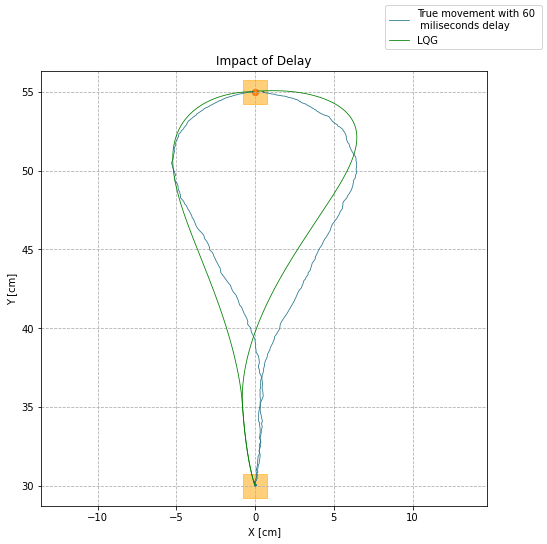

In [2]:
fig,ax = plt.subplots(figsize = (8,8))

for side in ["Right","Left"]:
    Feedback_Linearization(Num_iter = 300,Delay=.06,Activate_Noise=True,alpha = 1e-1,Side = side)
    LQG(starting_point=[0,30],plot = True,Delay = .06,Side = side)

hand, labl = ax.get_legend_handles_labels()
handout,lablout =[],[]
for h,l in zip(hand,labl):
    if l not in lablout:
        lablout.append(l)
        handout.append(h)
fig.legend(handout, lablout)
plt.title("Impact of Delay")
plt.show()